In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import ray
from ray import tune, train


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import datasets from torchvision.datasets libary
cifar100_train = dsets.CIFAR100(root='CIFAR100/', train=True, transform=transforms.ToTensor(), download=True)
cifar100_test = dsets.CIFAR100(root='CIFAR100/', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Checking if the classes in cifar100 arent superclasses
print(cifar100_train.classes)
print(cifar100_train.data.shape)
print(cifar100_test.data.shape)
print(type(cifar100_train))
# checking the dimensions of cifar100 training and test sets

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

(32, 32, 3)


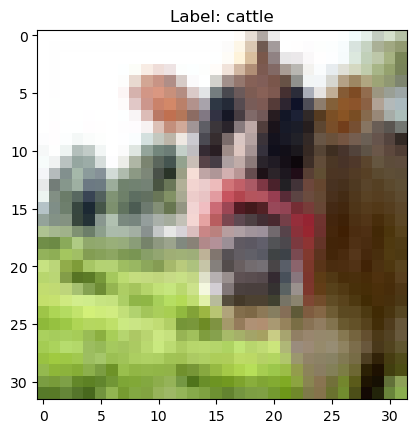

In [4]:
# Get the first image and its label
img, lab = cifar100_train[0]
# Transpose the image shape from (C, H, W) to (H, W, C) for plotting
img = img.numpy().transpose(1, 2, 0)
print(img.shape)
# Plot the image
plt.imshow(img)
plt.title(f'Label: {cifar100_train.classes[lab]}')
plt.show()

In [5]:
# Determine the sizes of the splits to ensure it is 1/5
num_validate = int(len(cifar100_train)/5)
num_train = len(cifar100_train) - num_validate
print(f'num_train: {num_train}')
print(f'num_validate: {num_validate}')
subtrain_dataset, validation_dataset = random_split(cifar100_train, [num_train, num_validate])

num_train: 40000
num_validate: 10000


In [6]:
# Model of a simpel CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolution Block 1
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(256)
        self.conv1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Convolution Block 2
        self.conv2_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(512)
        self.conv2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Convolution Block 3
        self.conv3_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(512)
        self.conv3_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        # Convolution Block 4
        self.conv4_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)  # Adjust the flattened size accordingly
        self.bn_fc = nn.BatchNorm1d(1024, momentum=0.95, eps=0.005)
        self.dropout_fc = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 100)  # 100 classes for CIFAR-100

    def forward(self, x):
        # Convolution Block 1
        x = self.dropout1(self.pool1(F.relu(self.bn1_2(F.relu(self.bn1_1(self.conv1_1(x)))))))
        
        # Convolution Block 2
        x = self.dropout2(self.pool2(F.relu(self.bn2_2(F.relu(self.bn2_1(self.conv2_1(x)))))))
        
        # Convolution Block 3
        x = self.dropout3(self.pool3(F.relu(self.bn3_2(F.relu(self.bn3_1(self.conv3_1(x)))))))

        # Convolution Block 4
        x = self.dropout4(self.pool4(F.relu(self.bn4_2(F.relu(self.bn4_1(self.conv4_1(x)))))))

        # Flatten and Fully Connected Layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout_fc(F.relu(self.bn_fc(self.fc1(x))))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [10]:
def train_val_model(config):
    model = CNN().to(device)

    subtrain_loader = DataLoader(subtrain_dataset, batch_size=config["batch_size"], shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"], shuffle=False)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer= optim.RMSprop(model.parameters(),lr=config["lr"])
    # optimizer= optim.RMSprop(model.parameters(),lr=1e-4)

    
    tr_acc = []
    tr_loss = []
    
    val_acc = []
    val_loss = []
    
    total_batch = len(subtrain_loader)
    num_epochs = 350
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in subtrain_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Calculate predictions for train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        train_accuracy = correct_train / total_train
        tr_acc.append(train_accuracy)
        train_loss = running_loss / len(subtrain_loader)
        tr_loss.append(train_loss)
        
        # print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
        # Validation loop
        model.eval()
        validation_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        validation_loss /= len(validation_loader)
        val_loss.append(validation_loss)
        validation_accuracy =  correct / total
        val_acc.append(validation_accuracy)
        # print(f'Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')  
        tune.report(val_accuracy=validation_loss, tr_accuracy=train_accuracy, val_loss=validation_loss, tr_loss=train_loss)
    print('Finished Training')
    #return tr_acc, tr_loss, val_acc, val_loss


def test_model(model,test_loader):
    #model = model.to(device)
    model.eval()

    with torch.no_grad():
        total = 0
        correct = 0
        n_class_correct = [0 for i in range(100)]
        n_class_samples = [0 for i in range(100)]
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # for i in range(labels.size(0)):
            #     label = labels[i]
            #     pred = predicted[i]
            #     if (label == pred):
            #         n_class_correct[label] += 1
            #     n_class_samples[label] += 1
                
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # for i in range(100):
    #     acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    #     print(f'Accuracy of {classes[i]}: {acc} %')

def plot_model(tr_acc, tr_loss, val_acc, val_loss):
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [8]:
# define for search space for hyperparameters
search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    # "momentum": tune.uniform(0.1, 0.9),
    # "dampening": tune.uniform(0.0, 0.5),
    "batch_size": 64  # Example of tuning batch size as well
}


# define short name for the trail
def short_trial_dirname_creator(trial):
    """Creates a shorter directory name for the trial."""
    return f"trial_{trial.trial_id}"


In [9]:
# Initialize Ray
ray.shutdown()
ray.init()
# Run the Ray Tune experiment
analysis = tune.run(
    train_val_model,
    resources_per_trial={"cpu": 1, "gpu": 1 if torch.cuda.is_available() else 0},
    config=search_space,
    num_samples=10,
    metric="val_accuracy",
    mode="max",
    local_dir= "tune_checkpoints",
    trial_dirname_creator=short_trial_dirname_creator
)
best_trial = analysis.get_best_trial("val_accuracy", "max", "all")
best_hyperparameters = best_trial.config

print(f"Best hyperparameters: {best_hyperparameters}")

ray.shutdown()

2024-04-14 21:57:16,422	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-04-14 21:57:18,818	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
C:\Users\Johnn\anaconda3\envs\cuda_test\lib\site-packages\ray\tune\tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the `RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(


ValueError: Tracked actor is not managed by this event manager: <TrackedActor 171924513043530157891457166155502041864>